<a href="https://colab.research.google.com/github/ctarrington/data-science-hw/blob/master/dbda/ch09-heirarchical-models/heirarchical_binomial_baseball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
from runpy import run_path

az.style.use('arviz-darkgrid')
%matplotlib inline

In [2]:
!rm -rf data-science-hw
!git clone https://github.com/ctarrington/data-science-hw.git

base_path = './data-science-hw/dbda/ch09-heirarchical-models'

Cloning into 'data-science-hw'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (187/187), done.
remote: Total 210 (delta 99), reused 44 (delta 13), pack-reused 0
Receiving objects: 100% (210/210), 9.76 MiB | 11.26 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [3]:
consolidated = pd.read_csv(base_path+'/BattingAverage.csv')
consolidated.drop(columns=['Player', 'PriPos'], inplace=True)
consolidated.rename(columns={'Hits': 'successes', 'AtBats': 'attempts', 'PlayerNumber': 'individual_id', 'PriPosNumber': 'category_id'}, inplace=True)

min_category_id = np.min(consolidated['category_id'])
min_individual_id = np.min(consolidated['individual_id'])

consolidated['category_id'] = consolidated['category_id'] - min_category_id
consolidated['individual_id'] = consolidated['individual_id'] - min_individual_id
consolidated.head()


,successes,attempts,individual_id,category_id
0,1,7,0,0
1,53,219,1,6
2,18,70,2,3
3,137,607,3,3
4,21,86,4,2


In [4]:
num_individuals = len(consolidated)
num_categories = len(np.unique(consolidated['category_id']))

print('num_individuals', num_individuals, 'num_categories', num_categories)

individual_id = consolidated['individual_id']
category_id = consolidated['category_id']


num_individuals 948 num_categories 9


## No Heirarchy - Individuals

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_individual]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:20<00:00, 123.51it/s]


                    mean     sd  hpd_3%  ...  ess_bulk  ess_tail  r_hat
p_individual[0]    0.221  0.130   0.015  ...    7279.0    2082.0    1.0
p_individual[1]    0.244  0.029   0.190  ...    9077.0    2617.0    1.0
p_individual[2]    0.264  0.051   0.174  ...    9032.0    2845.0    1.0
p_individual[3]    0.226  0.017   0.194  ...    9286.0    2875.0    1.0
p_individual[4]    0.250  0.044   0.171  ...    7278.0    2234.0    1.0
...                  ...    ...     ...  ...       ...       ...    ...
p_individual[943]  0.334  0.178   0.045  ...    7418.0    2586.0    1.0
p_individual[944]  0.283  0.019   0.247  ...    8309.0    2865.0    1.0
p_individual[945]  0.204  0.052   0.111  ...    9923.0    2703.0    1.0
p_individual[946]  0.091  0.039   0.027  ...    5891.0    2350.0    1.0
p_individual[947]  0.270  0.018   0.237  ...    7334.0    2624.0    1.0

[948 rows x 11 columns]


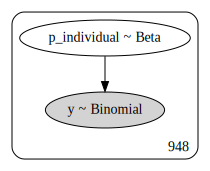

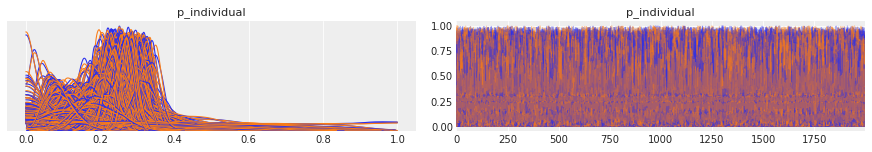

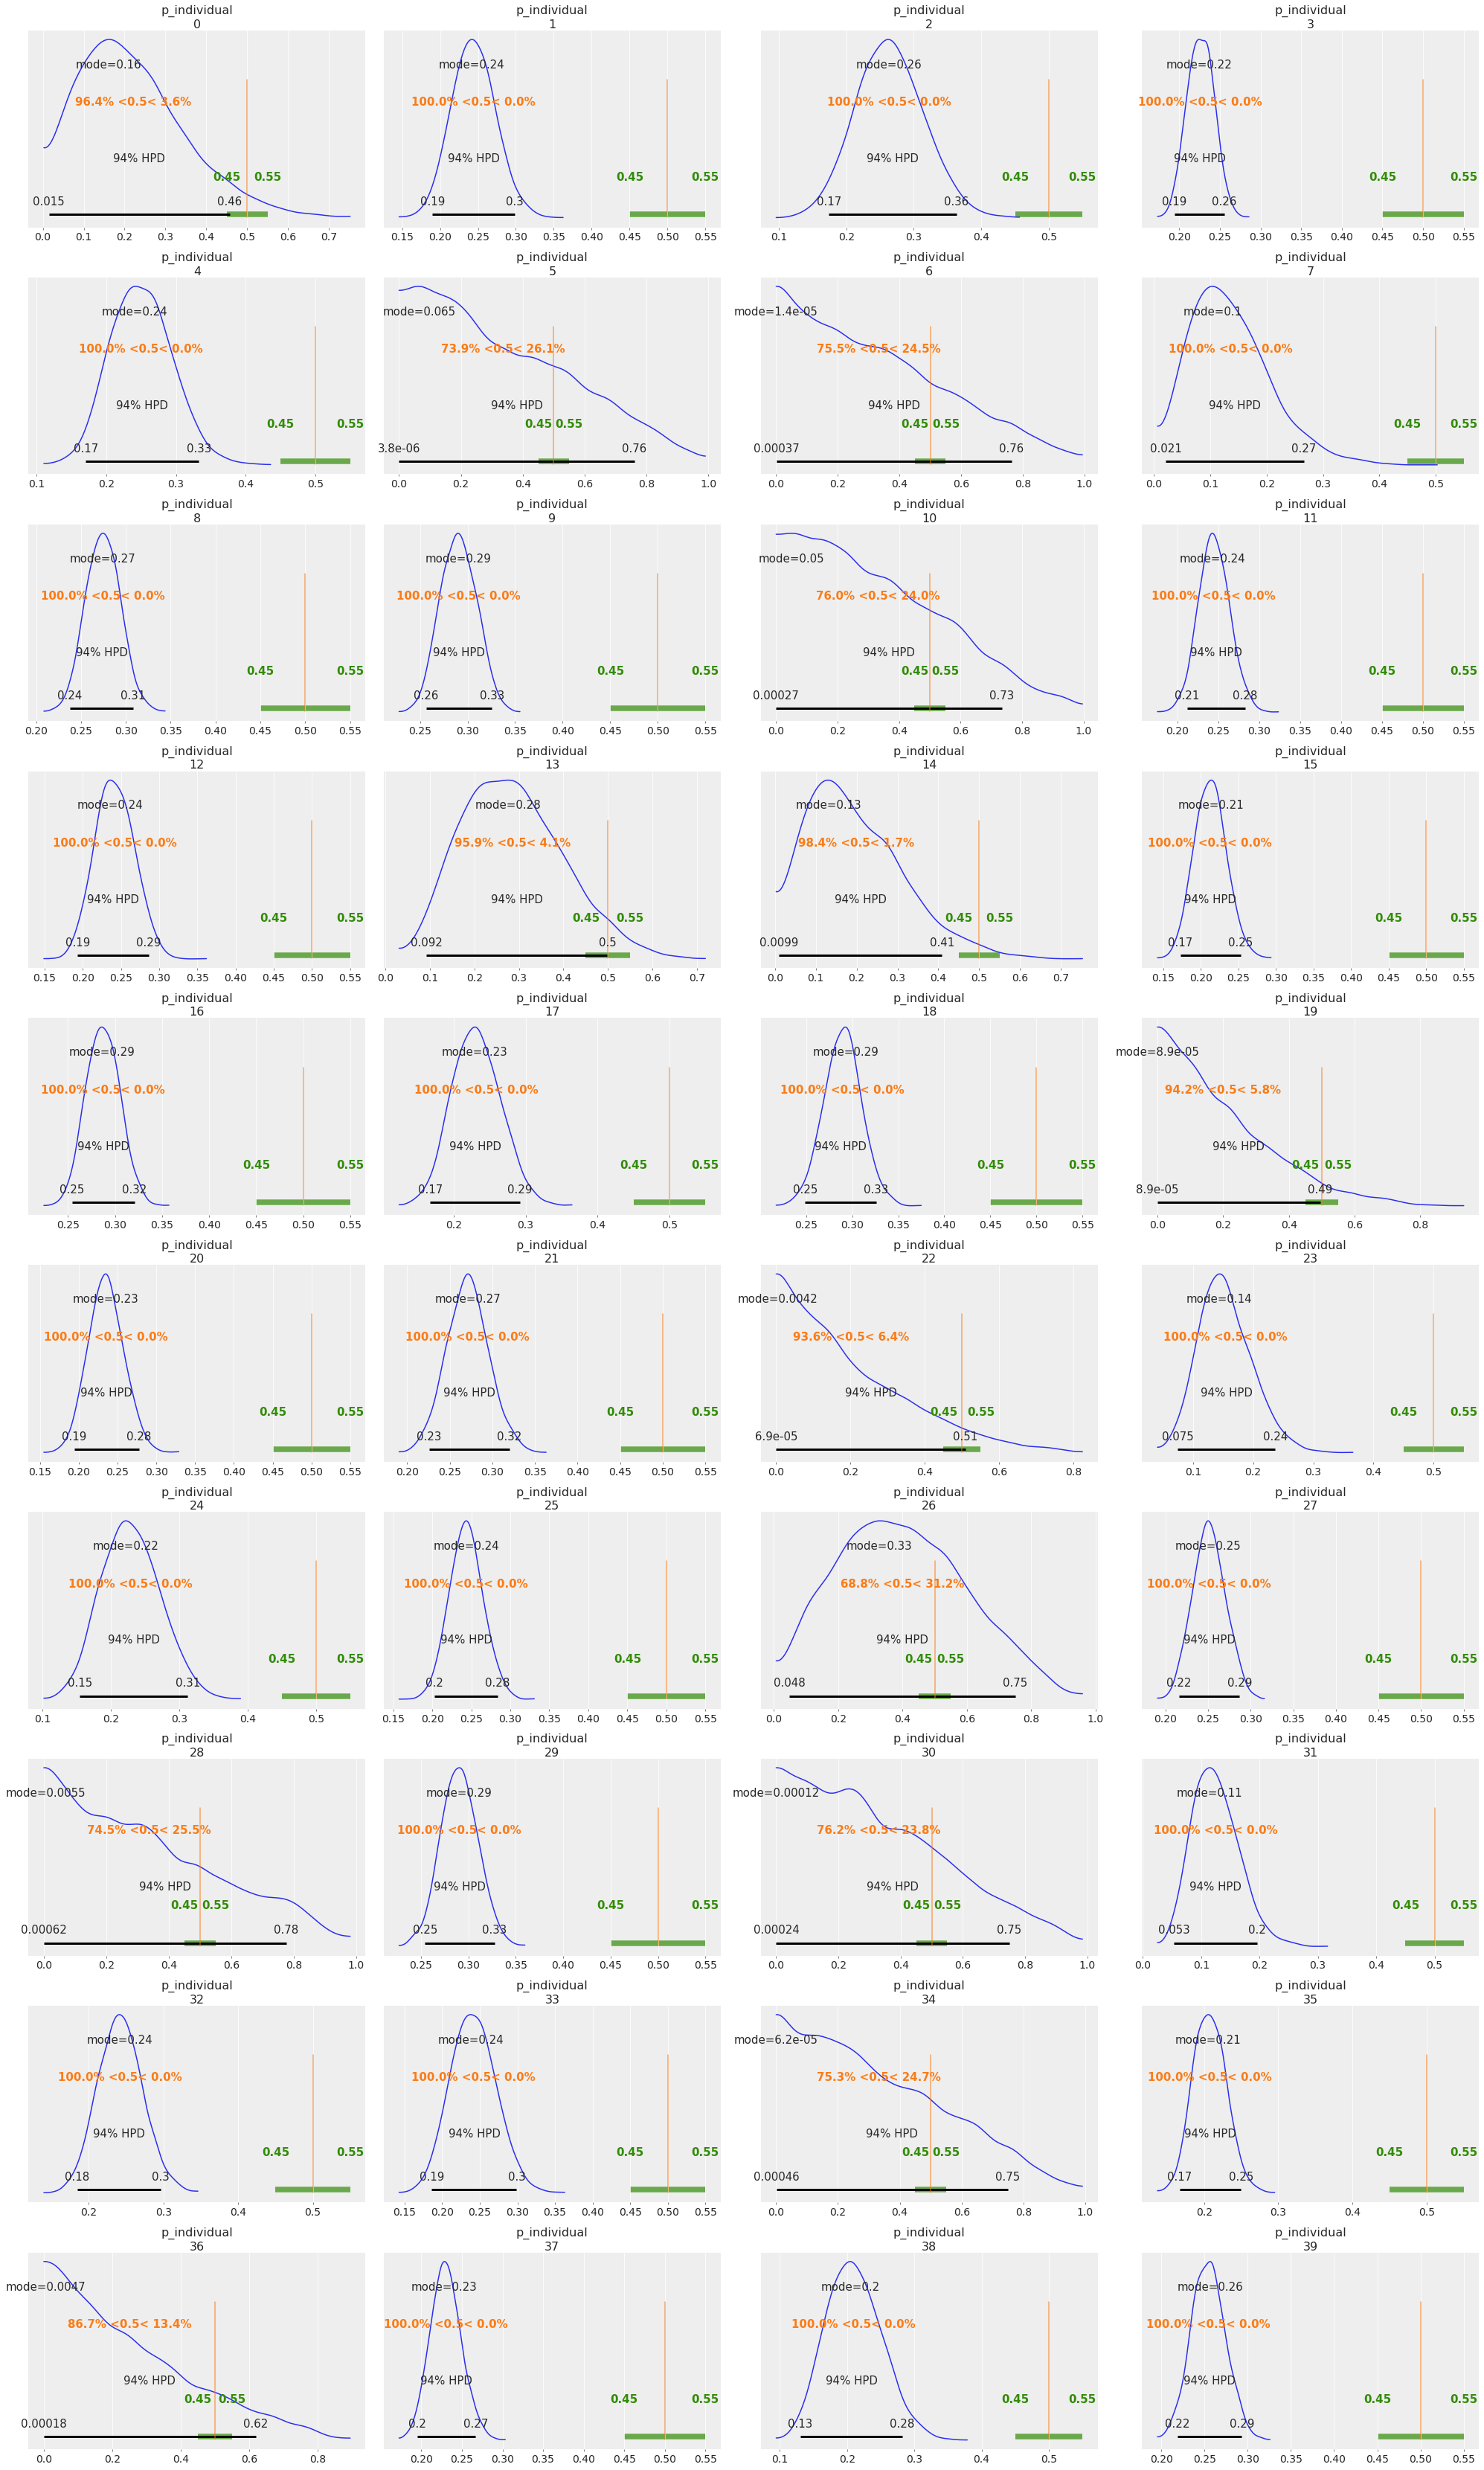

In [5]:
with pm.Model() as model_nh:
  p_individual = pm.Beta('p_individual', alpha=1., beta=1., shape=num_individuals)   # uniform prior
  
  y = pm.Binomial('y', n=consolidated['attempts'], p=p_individual[individual_id], observed=consolidated['successes']) # likelihood p(y|θ)

  trace_nh = pm.sample(2000, random_seed=123)
  print(az.summary(trace_nh))
  pm.traceplot(trace_nh)
  az.plot_posterior(trace_nh, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model_nh)

## Heirarchy - No Overall


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_individual, concentration_category, p_category]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:54<00:00, 45.51it/s]
The number of effective samples is smaller than 25% for some parameters.


                    mean     sd  hpd_3%  ...  ess_bulk  ess_tail  r_hat
p_category[0]      0.130  0.007   0.119  ...    1189.0    1943.0    1.0
p_category[1]      0.239  0.008   0.225  ...    4156.0    3164.0    1.0
p_category[2]      0.253  0.008   0.238  ...    5214.0    3142.0    1.0
p_category[3]      0.249  0.009   0.233  ...    4115.0    3165.0    1.0
p_category[4]      0.255  0.009   0.238  ...    4827.0    3127.0    1.0
...                  ...    ...     ...  ...       ...       ...    ...
p_individual[943]  0.143  0.056   0.049  ...    6963.0    2645.0    1.0
p_individual[944]  0.280  0.018   0.246  ...    7941.0    2699.0    1.0
p_individual[945]  0.169  0.038   0.101  ...    6235.0    2685.0    1.0
p_individual[946]  0.097  0.031   0.039  ...    6782.0    2578.0    1.0
p_individual[947]  0.269  0.018   0.235  ...    7841.0    2638.0    1.0

[966 rows x 11 columns]


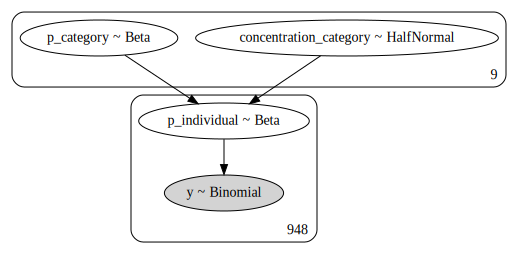

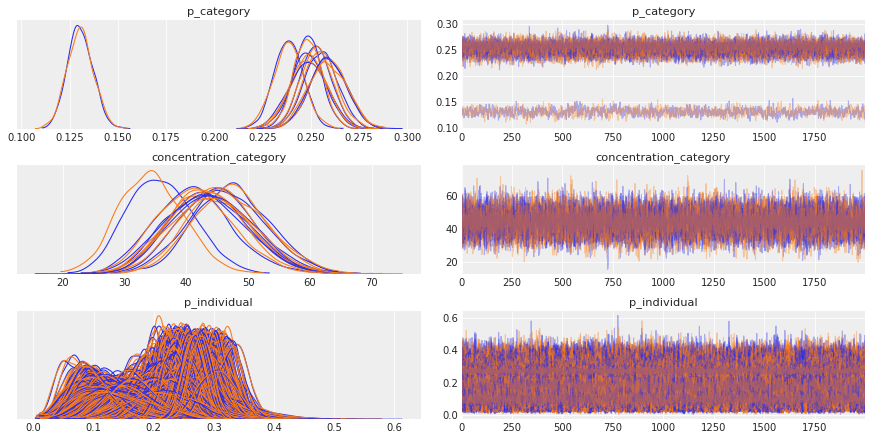

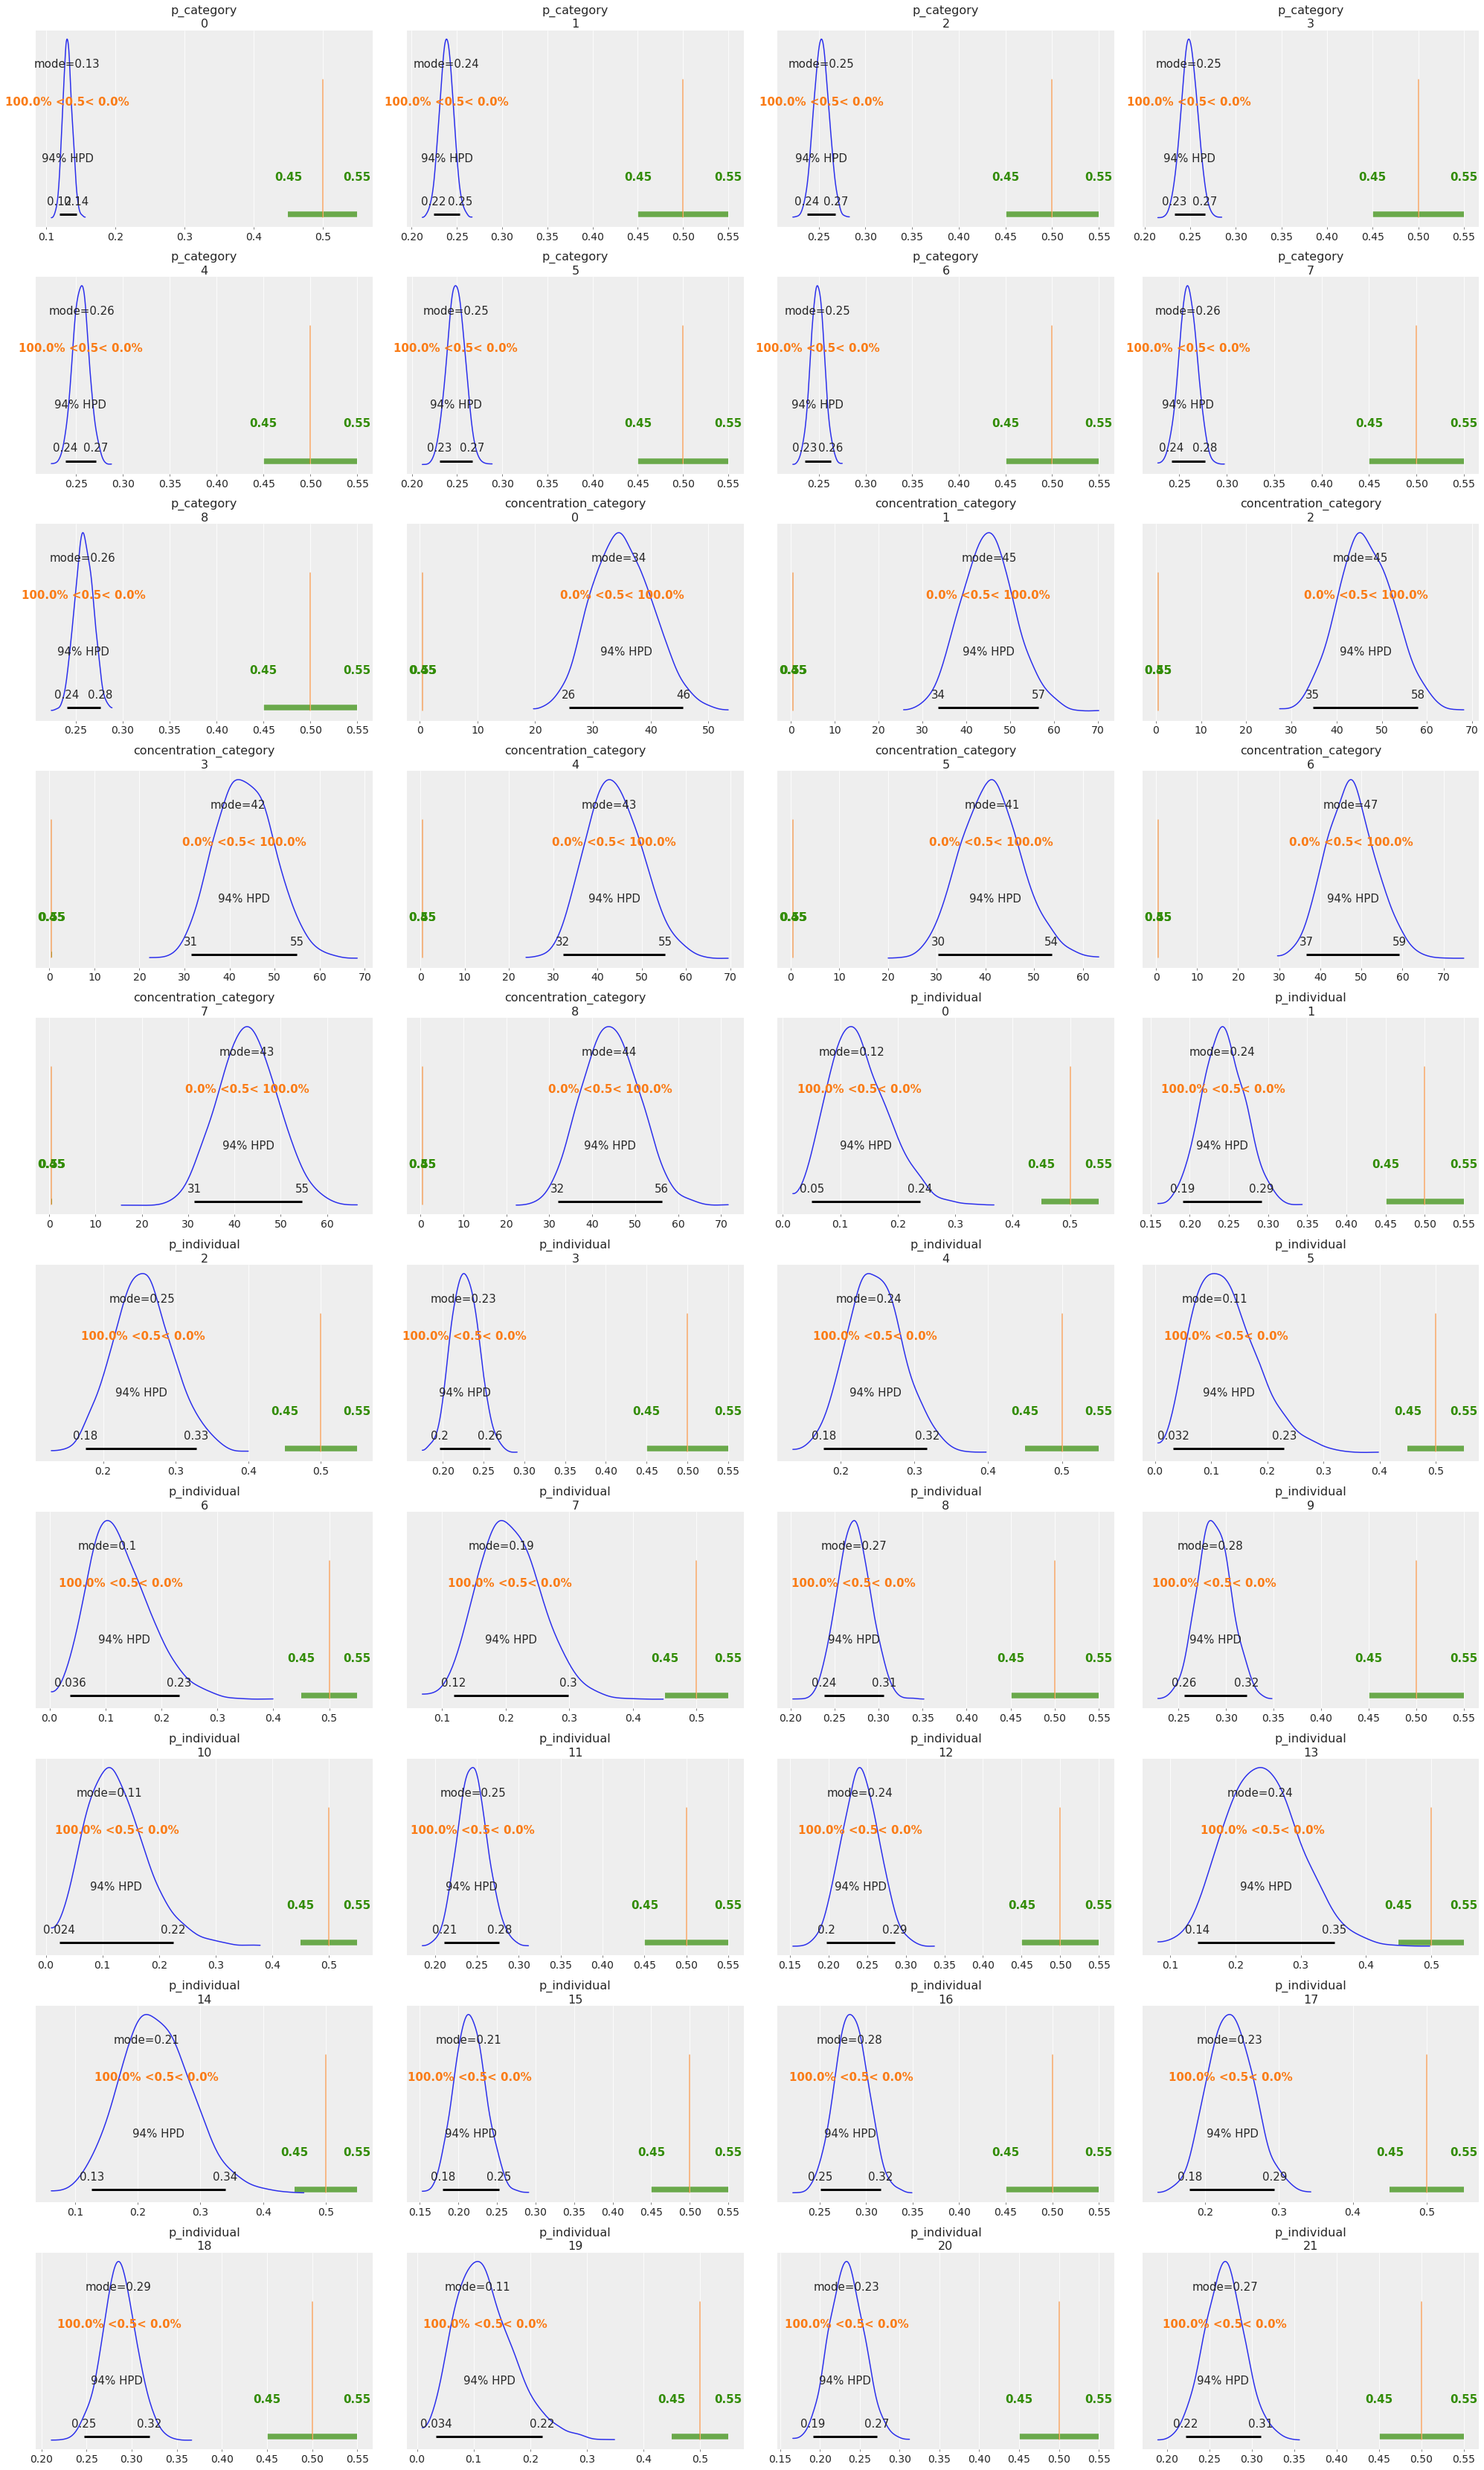

In [6]:
with pm.Model() as model_h:
  p_category = pm.Beta('p_category', 1, 1, shape=num_categories)
  concentration_category = pm.HalfNormal('concentration_category', 10, shape=num_categories)

  p_individual = pm.Beta('p_individual',
                       alpha=p_category[category_id]*concentration_category[category_id],
                       beta=(1.0-p_category[category_id])*concentration_category[category_id],
                       shape=num_individuals)
  
  y = pm.Binomial('y', n=consolidated['attempts'], p=p_individual[individual_id], observed=consolidated['successes']) # likelihood p(y|θ)

  trace_h = pm.sample(2000, random_seed=123)
  print(az.summary(trace_h))
  pm.traceplot(trace_h)
  az.plot_posterior(trace_h, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model_h)

## Heirarchy with Overall

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_individual, concentration_category, p_category, concentration_overall, p_overall]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:57<00:00, 43.83it/s]
The number of effective samples is smaller than 25% for some parameters.


                         mean     sd  hpd_3%  ...  ess_bulk  ess_tail  r_hat
p_overall               0.251  0.033   0.189  ...    5101.0    2521.0    1.0
concentration_overall  19.514  6.358   8.211  ...    4081.0    2252.0    1.0
p_category[0]           0.131  0.006   0.120  ...    1181.0    2163.0    1.0
p_category[1]           0.238  0.008   0.224  ...    3778.0    2883.0    1.0
p_category[2]           0.252  0.008   0.237  ...    4839.0    2867.0    1.0
...                       ...    ...     ...  ...       ...       ...    ...
p_individual[943]       0.143  0.056   0.040  ...    6067.0    2506.0    1.0
p_individual[944]       0.281  0.018   0.247  ...    6513.0    2680.0    1.0
p_individual[945]       0.170  0.039   0.097  ...    6061.0    2068.0    1.0
p_individual[946]       0.097  0.031   0.042  ...    5890.0    2653.0    1.0
p_individual[947]       0.268  0.017   0.236  ...    5488.0    2655.0    1.0

[968 rows x 11 columns]


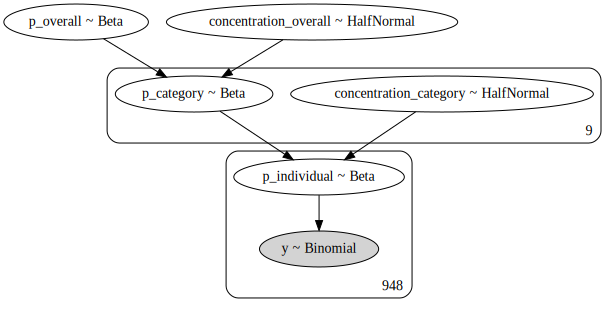

In [7]:
with pm.Model() as model_h_o:
  p_overall = pm.Beta('p_overall', 1, 1)
  concentration_overall = pm.HalfNormal('concentration_overall', 10)

  
  p_category = pm.Beta('p_category',
                       alpha=p_overall*concentration_overall,
                       beta=(1.0-p_overall)*concentration_overall,
                       shape=num_categories)
  concentration_category = pm.HalfNormal('concentration_category', 10, shape=num_categories)

  p_individual = pm.Beta('p_individual',
                       alpha=p_category[category_id]*concentration_category[category_id],
                       beta=(1.0-p_category[category_id])*concentration_category[category_id],
                       shape=num_individuals)
  
  y = pm.Binomial('y', n=consolidated['attempts'], p=p_individual[individual_id], observed=consolidated['successes']) # likelihood p(y|θ)

  trace_h_o = pm.sample(2000)
  print(az.summary(trace_h_o))
  # pm.traceplot(trace_h_o)
  # az.plot_posterior(trace_h_o, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model_h_o)

In [8]:
raw = pd.read_csv(base_path+'/BattingAverage.csv')
raw.drop(columns=['Player', 'Hits', 'AtBats', 'PlayerNumber'], inplace=True)
raw.drop_duplicates(inplace=True)
raw.sort_values(by='PriPosNumber', inplace=True)
positions = raw['PriPos'].to_numpy()
print(positions)

['Pitcher' 'Catcher' '1st Base' '2nd Base' '3rd Base' 'Shortstop'
 'Left Field' 'Center Field' 'Right Field']


In [9]:
data_h_o = az.from_pymc3(
    trace=trace_h_o,
    # prior=prior,
    # posterior_predictive=posterior_predictive,
    model=model_h_o,
    coords={"category": positions},
    dims={"p_category": ["category"]},
)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ba9187400>],
      dtype=object)

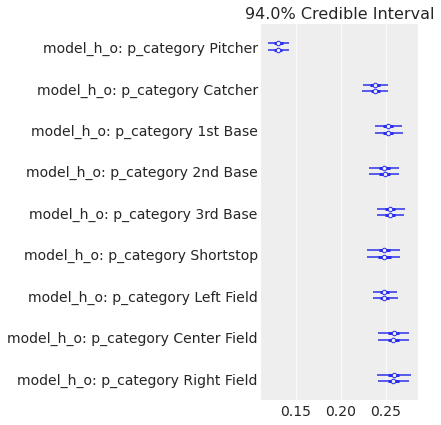

In [10]:
az.plot_forest(data_h_o,
               model_names=['model_h_o'],
               var_names='p_category')

In [11]:
mid_point = trace_h_o['p_overall'].mean()
mid_point = round(mid_point, 2)
left_point = round(mid_point-mid_point*0.1, 2)
right_point = round(mid_point+mid_point*0.1, 2)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bb2b3bda0>,
      dtype=object)

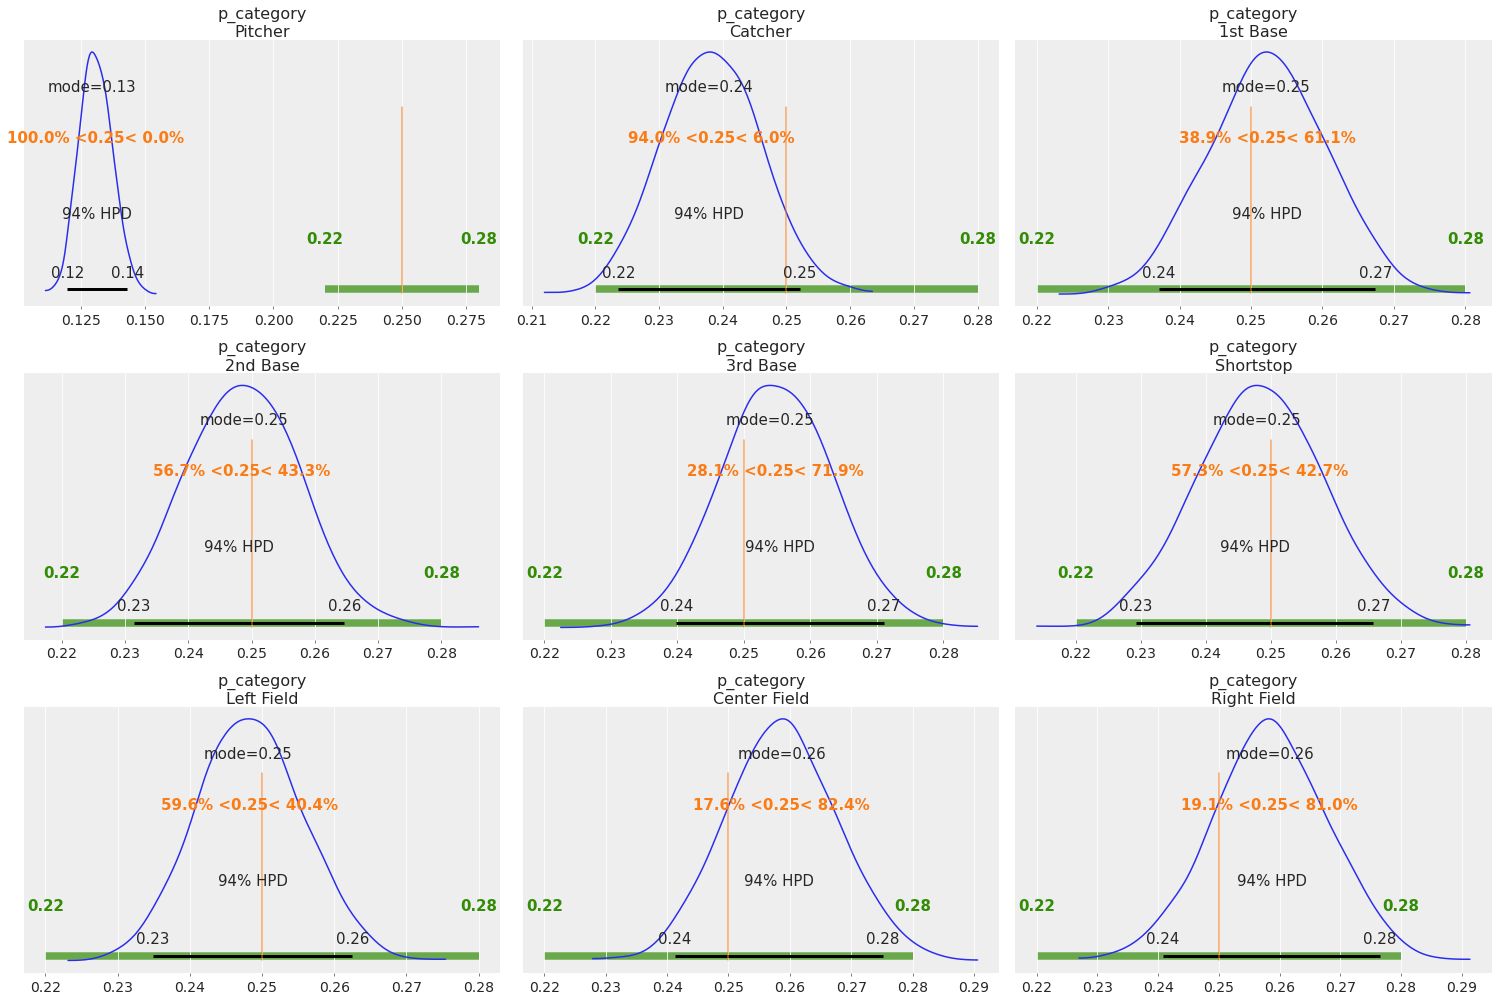

In [12]:
az.plot_posterior(data_h_o, rope=[left_point, right_point], ref_val=mid_point, point_estimate='mode', var_names='p_category')